In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from helpers.helper_functions import *

# Handling text 2 exercise
[Handling text exercisses ADApted drom ADA 2018 final exam]

The Sheldon Cooper we all know and love (OK, some of us might not know him, and some might not love him) from the TV series "The Big Bang Theory" has gotten into an argument with Leonard from the same TV show. Sheldon insists that he knows the show better than anyone, and keeps making various claims about the show, which neither of them know how to prove or disprove. The two of them have reached out to you ladies and gentlemen, as data scientists, to help them. You will be given the full script of the series, with information on the episode, the scene, the person saying each dialogue line, and the dialogue lines themselves.

Leonard has challenged several of Sheldon's claims about the show, and throughout this exam you will see some of those and you will get to prove or disprove them, but remember: sometimes, we can neither prove a claim, nor disprove it!

## Task A: Picking up the shovel

**Note: You will use the data you preprocess in this task in all the subsequent ones.**

Our friends' argument concerns the entire show. We have given you a file in the `data/` folder that contains the script of every single episode. New episodes are indicated by '>>', new scenes by '>', and the rest of the lines are dialogue lines. Some lines are said by multiple people (for example, lines indicated by 'All' or 'Together'); **you must discard these lines**, for the sake of simplicity. However, you do not need to do it for Q1 in this task -- you'll take care of it when you solve Q2.

**Q1**. Your first task is to extract all lines of dialogue in each scene and episode, creating a dataframe where each row has the episode and scene where a dialogue line was said, the character who said it, and the line itself. You do not need to extract the proper name of the episode (e.g. episode 1 can appear as "Series 01 Episode 01 - Pilot Episode", and doesn't need to appear as "Pilot Episode"). Then, answer the following question: In total, how many scenes are there in each season? We're not asking about unique scenes; the same location appearing in two episodes counts as two scenes. You can use a Pandas dataframe with a season column and a scene count column as the response.

**Note: The data refers to seasons as "series".**

---

In [2]:
import codecs
file_path = 'data/all_scripts.txt'
with codecs.open(file_path, 'r', 'utf-8') as f:
    raw = f.read().strip('\n').split('\n')
    
raw[:3]

['>> Series 01 Episode 01 – Pilot\xa0Episode',
 '> A corridor at a sperm bank.',
 'Sheldon: So if a photon is directed through a plane with two slits in it and either slit is observed it will not go through both slits. If it’s unobserved it will, however, if it’s observed after it’s left the plane but before it hits its target, it will not have gone through both slits.']

**QUESTION: bad encoding for the `\xa0` character (1st line)?**

We first parse the raw text file:

In [3]:
parse_episode = lambda s: s[3:]
parse_scene = lambda s: s[2:]

print(parse_episode(raw[0]))
print(parse_scene(raw[1]))

Series 01 Episode 01 – Pilot Episode
A corridor at a sperm bank.


In [4]:
def parse_dialog_line(line):
    i = line.find(':')
    return line[:i], line[i+2:] # +2 to skip : as well as the following space

parse_dialog_line(raw[2])

('Sheldon',
 'So if a photon is directed through a plane with two slits in it and either slit is observed it will not go through both slits. If it’s unobserved it will, however, if it’s observed after it’s left the plane but before it hits its target, it will not have gone through both slits.')

In [5]:
# List of tuples: (episode, scene, character, dialog line)
rows = []

cur_episode, cur_scene = parse_episode(raw[0]), parse_scene(raw[1])
for line in raw[2:]:
    if line.startswith('>>'): # new episode
        cur_episode = parse_episode(line)
        cur_scene = np.nan
    elif line.startswith('>'): # new scene
        cur_scene = parse_scene(line)
    else: # simple line
        character, dialog = parse_dialog_line(line)
        rows.append((
            cur_episode, cur_scene, character, dialog
        ))

And convert it to a DataFrame:

In [6]:
df = pd.DataFrame(rows, columns=['episode', 'scene', 'character', 'line'])
df

,episode,scene,character,line
0,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,So if a photon is directed through a plane wit...
1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,"Agreed, what’s your point?"
2,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,"There’s no point, I just think it’s a good ide..."
3,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,Excuse me?
4,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Receptionist,Hang on.
...,...,...,...,...
51287,Series 10 Episode 24 – The Long Distance Disso...,Sheldon’s office.,Ramona,"Mmm. No big deal, I enjoy spending time with you."
51288,Series 10 Episode 24 – The Long Distance Disso...,Sheldon’s office.,Sheldon,"And I with you. Question, are you seeking a ro..."
51289,Series 10 Episode 24 – The Long Distance Disso...,Sheldon’s office.,Ramona,What if I were?
51290,Series 10 Episode 24 – The Long Distance Disso...,Sheldon’s office.,Sheldon,"Well, that would raise a number of problems. W..."


We first count the number of unique scenes by episode:

In [7]:
df.groupby('episode').scene.nunique()

episode
Series 01 Episode 01 – Pilot Episode                   12
Series 01 Episode 02 – The Big Bran Hypothesis         11
Series 01 Episode 03 – The Fuzzy Boots Corollary       11
Series 01 Episode 04 – The Luminous Fish Effect        14
Series 01 Episode 05 – The Hamburger Postulate          8
                                                       ..
Series 10 Episode 20 – The Recollection Dissipation     9
Series 10 Episode 21 – The Separation Agitation         7
Series 10 Episode 22 – The Cognition Regeneration      10
Series 10 Episode 23 – The Gyroscopic Collapse          9
Series 10 Episode 24 – The Long Distance Dissonance     9
Name: scene, Length: 231, dtype: int64

And then sum those unique scenes per episode to a count of scenes per season:

In [8]:
df_scenes = pd.DataFrame(df.groupby('episode').scene.nunique()).reset_index()
# Add column 'season'
df_scenes['season'] = df_scenes.episode.apply(lambda s: s.split(' ')[1])

# Group by season and count scenes
df_scenes = pd.DataFrame(df_scenes.groupby('season').scene.sum())
df_scenes.columns = ['n_scenes']

df_scenes

,n_scenes
season,
01,157
02,205
03,193
04,219
05,198
06,211
07,207
08,191
09,177


---

**Q2**. Now, let's define two sets of characters: all the characters, and recurrent characters. Recurrent characters are those who appear in more than one episode. For the subsequent sections, you will need to have a list of recurrent characters. Assume that there are no two _named characters_ (i.e. characters who have actual names and aren't referred to generically as "little girl", "grumpy grandpa", etc.) with the same name, i.e. there are no two Sheldons, etc. Generate a list of recurrent characters who have more than 90 dialogue lines in total, and then take a look at the list you have. If you've done this correctly, you should have a list of 20 names. However, one of these is clearly not a recurrent character. Manually remove that one, and print out your list of recurrent characters. To remove that character, pay attention to the _named character_ assumption we gave you earlier on. **For all the subsequent questions, you must only keep the dialogue lines said by the recurrent characters in your list.**

---

We recall that recurrent characters are the ones who appear in more than one episode, so we group by character and count the episodes (this gives a count of the number of episode per character):

In [9]:
char_episode_count = df.groupby('character').episode.nunique()
char_episode_count

character
Abby                  1
Actress               1
Adam                  2
Air Force Officer     1
Alex                  4
                     ..
Woman                10
Woman on TV           2
Wyatt                 2
Zack                  8
Zombie                1
Name: episode, Length: 198, dtype: int64

We filter out characters having a single episode:

In [10]:
recurrent_characters = char_episode_count > 1
recurrent_characters = char_episode_count[recurrent_characters].index.tolist()
print(recurrent_characters)

['Adam', 'Alex', 'Alfred', 'All', 'Amy', 'Arthur', 'Assistant', 'Barman', 'Barry', 'Bernadette', 'Bert', 'Beverley', 'Beverly', 'Both', 'Claire', 'Col. Williams', 'Colonel Williams', 'Dan', 'Dave', 'Dimitri', 'Doctor', 'Emily', 'Everyone', 'Female Voice', 'Gablehauser', 'Gablehouser', 'Girl', 'Girls', 'Guy', 'Howard', 'Howard and Bernadette', 'Howard and Raj', 'Howard’s Mother', 'Ira', 'Janine', 'Katee Sackhoff', 'Kevin', 'Kripke', 'Kurt', 'LeVar', 'Leonard', 'Leonard and Howard', 'Lesley', 'Leslie', 'Lucy', 'Man', 'Man on TV', 'Mary', 'Mike', 'Mr Rostenkowski', 'Mr. Rostenkowski', 'Mrs Cooper', 'Mrs Davis', 'Mrs Hofstadter', 'Mrs Koothrappali', 'Mrs Wolowitz', 'Nurse', 'Penny', 'Penny’s Dad', 'Policeman', 'Priya', 'Raj', 'Ramona', 'Receptionist', 'Santa', 'Security Guard', 'Seibert', 'Sheldon', 'Siri', 'Spock', 'Steph', 'Stephen Hawking', 'Stuart', 'Summer', 'Together', 'Voice', 'Waiter', 'Waitress', 'Wil', 'Wil Wheaton', 'Woman', 'Woman on TV', 'Wyatt', 'Zack']


We count the number of lines per character:

In [11]:
char_lines = df.groupby('character').line.count()
char_lines

character
Abby                   4
Actress                5
Adam                  19
Air Force Officer      6
Alex                  63
                    ... 
Woman                 25
Woman on TV            5
Wyatt                 42
Zack                 135
Zombie                 6
Name: line, Length: 198, dtype: int64

We filter out characters having less than 90 dialogue lines by taking the intersection between characters having more than 90 lines and recurrent characters:

In [12]:
char_more_90_lines = char_lines > 90
char_more_90_lines = char_more_90_lines[char_more_90_lines].index.tolist()
print(char_more_90_lines)

['Amy', 'Arthur', 'Bernadette', 'Bert', 'Beverley', 'Emily', 'Howard', 'Kripke', 'Leonard', 'Leslie', 'Man', 'Mrs Cooper', 'Mrs Wolowitz', 'Penny', 'Priya', 'Raj', 'Sheldon', 'Stuart', 'Wil', 'Zack']


In [13]:
characters = np.intersect1d(recurrent_characters, char_more_90_lines)
print(characters.size)
characters

20


array(['Amy', 'Arthur', 'Bernadette', 'Bert', 'Beverley', 'Emily',
       'Howard', 'Kripke', 'Leonard', 'Leslie', 'Man', 'Mrs Cooper',
       'Mrs Wolowitz', 'Penny', 'Priya', 'Raj', 'Sheldon', 'Stuart',
       'Wil', 'Zack'], dtype='<U21')

We indeed have 20 characters in the end (although those are the same as characters with > 90 lines). We should **remove the "character" `Man`**:

In [14]:
final_chars = characters.tolist()
final_chars.remove('Man')
print(len(final_chars))
final_chars

19


['Amy',
 'Arthur',
 'Bernadette',
 'Bert',
 'Beverley',
 'Emily',
 'Howard',
 'Kripke',
 'Leonard',
 'Leslie',
 'Mrs Cooper',
 'Mrs Wolowitz',
 'Penny',
 'Priya',
 'Raj',
 'Sheldon',
 'Stuart',
 'Wil',
 'Zack']

We eventually filter the data to **keep lines said by the above characters**:

In [33]:
# Keep raw data in case we need it later
rawdf = df.copy()

In [34]:
df = df[df.character.isin(final_chars)]
df.shape

(48346, 5)

In [35]:
# Sanity check
df.character.nunique()

19

We now have a filtered dataframe (names `df`) containing our 19 recurrent characters with more than 90 lines.

---

## Task B: Read the scripts carefully

### Part 1: Don't put the shovel down just yet

**Q3**. From each dialogue line, replace punctuation marks (listed in the EXCLUDE_CHARS variable provided in `helpers/helper_functions.py`) with whitespaces, and lowercase all the text. **Do not remove any stopwords, leave them be for all the questions in this task.**

---

In order to replace characters in `EXCLUDE_CHARS` to whitespaces, we create a translation table with the helper function `str.maketrans`:

In [36]:
efficienttrans_table = str.maketrans({
    exclude_char: ' ' for exclude_char in EXCLUDE_CHARS
})

In [37]:
# Test
'Agreed, what’s your point?'.translate(trans_table)

'Agreed  what s your point '

We process each line with `apply` and perform string operations as asked. As a "backup" solution and as a mean of easy comparison, we rename the unprocessed `line` column to `raw_line` and create a new column `line` with the processed text:

In [38]:
df.rename(columns={'line': 'raw_line'}, inplace=True)

In [46]:
df['line'] = df.raw_line.apply(lambda s: s.translate(trans_table).lower())
df[['raw_line', 'line']]

,raw_line,line
0,So if a photon is directed through a plane wit...,so if a photon is directed through a plane wit...
1,"Agreed, what’s your point?",agreed what s your point
2,"There’s no point, I just think it’s a good ide...",there s no point i just think it s a good ide...
3,Excuse me?,excuse me
5,"One across is Aegean, eight down is Nabakov, t...",one across is aegean eight down is nabakov t...
...,...,...
51284,"Uh, breakfast yes, lunch no. I did have a coug...",uh breakfast yes lunch no i did have a coug...
51286,How thoughtful. Thank you.,how thoughtful thank you
51288,"And I with you. Question, are you seeking a ro...",and i with you question are you seeking a ro...
51290,"Well, that would raise a number of problems. W...",well that would raise a number of problems w...


---

**Q4**. For each term, calculate its "corpus frequency", i.e. its number of occurrences in the entire series. Visualize the distribution of corpus frequency using a histogram. Explain your observations. What are the appropriate x and y scales for this plot?

---

We assume that "term" means whitespace-delimited strings, more commonly referred as to words. To extract words from a given string, we use the function `simple_tokeniser` that is provided. To count words, we'll use the `collections.Counter`, that we will apply on a string of all joined lines (`str.join`). As an implementation note, we could have done:

```python
df.line.apply(simple_tokeniser).apply(Counter).sum()
```

But this is way (!!) less efficient in terms of computational time (the bottleneck is the `sum` operation).

In [48]:
from collections import Counter

In [56]:
merged_lines = ' '.join(df.line)
word_counts = Counter(simple_tokeniser(merged_lines))

We transform the word counts into a `pandas.Series`:

In [69]:
words = pd.Series(word_counts, name='count')
words

so               3187
if               2490
a               13518
photon              4
is               5444
                ...  
skyped              1
corresponded        1
nickels             1
highlighted         1
relation…           1
Name: count, Length: 21102, dtype: int64

In [62]:
import seaborn as sns

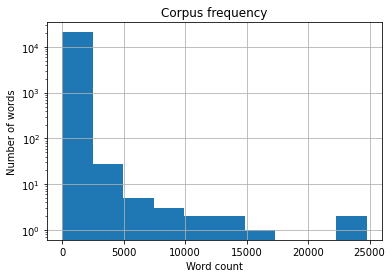

In [75]:
words.hist()
with sns.axes_style('whitegrid'):
    plt.yscale('log')

plt.xlabel('Word count')
plt.ylabel('Number of words')
plt.title('Corpus frequency');

We chose a **logarithmic y axis** since the histogram has the typical shape of word frequencies: the majority of words are present only a few times (the big spike on the left of the histogram), and few words are counted a big number of times (the small isolated peak on the right of the histogram):

---

### Part 2: Talkativity
**Q5**. For each of the recurrent characters, calculate their total number of words uttered across all episodes. Based on this, who seems to be the most talkative character?

---

We group the data by character, and process each character's lines in a similar manner as in Q4 (tokenize, set to lower case) and count the total number of words (no need to first count each word's occurence):

In [83]:
df.groupby('character').line.apply(lambda e: len(simple_tokeniser(' '.join(e)))).sort_values()

character
Bert              1146
Kripke            1246
Leslie            1249
Zack              1427
Arthur            1451
Mrs Wolowitz      1459
Emily             1571
Wil               1678
Priya             1940
Beverley          2029
Mrs Cooper        3389
Stuart            7955
Bernadette       27726
Amy              39933
Raj              60099
Howard           69505
Penny            79270
Leonard         102496
Sheldon         185388
Name: line, dtype: int64

Sheldon seems to be the most talktative character, with 185388 words in total.

---

## Task D: The Detective's Hat

Sheldon claims that given a dialogue line, he can, with an accuracy of above 70%, say whether it's by himself or by someone else. Leonard contests this claim, since he believes that this claimed accuracy is too high. Leonard also suspects that it's easier for Sheldon to distinguish the lines that _aren't_ his, rather than those that _are_. We want you to put on the (proverbial) detective's hat and to investigate this claim.

**Q6**. Divide the set of all dialogue lines into two subsets: the training set, consisting of all the seasons except the last two, and the test set, consisting of the last two seasons. Each of your data points (which is one row of your matrix) is one **dialogue line**. Now, use the scikit-learn class **TfIdfVectorizer** to create TF-IDF representations for the data points in your training and test sets. Note that since you're going to train a machine learning model, everything used in the training needs to be independent of the test set. As a preprocessing step, remove stopwords and words that appear only once from your vocabulary. Use the simple tokenizer provided in `helpers/helper_functions.py` as an input to the TfidfVectorizer class, and use the words provided in `helpers/stopwords.txt` as your stopwords.

---

**QUESTION & TODO: not clear if we should use processed data (lower case, replaced EXCLUDE_CHARS) or not**.

We first create a row `season` which will allow us to split the data:

In [87]:
df['season'] = df.episode.apply(lambda s: int(s.split(' ')[1]))
df.season.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [91]:
df_train = df[df.season < 9].copy()
df_test = df[df.season >= 9].copy()

# Sanity check
train.season.unique(), test.season.unique()

(array([1, 2, 3, 4, 5, 6, 7, 8]), array([ 9, 10]))

The data provided to `TfidfVectorizer` is simply a list / an array of documents (i.e. lines in our case):


In [92]:
train = df_train.line
test = df_test.line

The `TfidfVectorizer` class accepts the argument `stop_words`, which will remove any word that appears on the provided list. We can actually add words with a single occurence in this list, eventhough those rare words are not stop words as we typically think of them (in summary, the result is the same and there is no need to create a custom function to remove rare words, that would be reinventing the wheel and it's bad and pretentious).

The rare words must be computed on the **training** set, since the test set must not be inspected... before we want to test our model:

In [99]:
train_word_counts = Counter(simple_tokeniser(' '.join(train)))
train_word_counts = pd.Series(train_word_counts)
train_word_counts

so             2433
if             1892
a             10893
photon            4
is             4347
              ...  
glug              2
whiner            1
sway              1
untogether        1
slate             1
Length: 19508, dtype: int64

In [103]:
mask = (train_word_counts == 1)
train_words_single_occurence = train_word_counts[mask].index
print(f'{len(train_words_single_occurence)} words with a single occurence in train set')

8507 words with a single occurence in train set


We load the stop words provided in `stopwords.txt`:

In [107]:
with open('helpers/stopwords.txt', 'r') as f:
    stop_words = f.read().strip('\n').split('\n')
    
stop_words[:4]

['i', 'me', 'my', 'myself']

And merge the stop words with words having a single occurence:

In [109]:
exclude_words = stop_words + train_words_single_occurence.tolist()
print(f'{len(exclude_words)} words to exclude')

8647 words to exclude


We can now call `TfidfVectorize`: 

In [110]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [112]:
tfid = TfidfVectorizer(tokenizer=simple_tokeniser, stop_words=exclude_words)
X = tfid.fit_transform(train)

In [114]:
Xtest = tfid.transform(test)

In [209]:
tfid.get_feature_names()[-10:]

['“penny',
 '“release',
 '“soft',
 '“the',
 '“well',
 '“wesley”',
 '“what',
 '“you',
 '”',
 '…']

In [115]:
X, Xtest

(<38177x10862 sparse matrix of type '<class 'numpy.float64'>'
 	with 196876 stored elements in Compressed Sparse Row format>,
 <10169x10862 sparse matrix of type '<class 'numpy.float64'>'
 	with 47269 stored elements in Compressed Sparse Row format>)

---

**Q7**. Find the set of all words in the training set that are only uttered by Sheldon. Is it possible for Sheldon to identify himself only based on these? Use the test set to assess this possibility, and explain your method.

---

We first compute the words that are unique to Sheldon (no one else uttered those) in the **train set**:

In [127]:
# All words of Sheldon
words_sheldon = set(simple_tokeniser(' '.join(df_train[df_train.character == 'Sheldon'].line)))
# All words NOT of Shelon
words_not_sheldon = set(simple_tokeniser(' '.join(df_train[df_train.character != 'Sheldon'].line)))

In [133]:
# All words that only Sheldon uttered
words_only_sheldon = [
    word
    for word in words_sheldon
    if word not in words_not_sheldon
]

len(words_only_sheldon)

5269

We can imagine a very simple classifier: given a line, return 1 if it contains *any* word that is unique to Sheldon, return 0 otherwise.

In [137]:
# Create the ground truth target
ytest = (df_test.character == 'Sheldon') * 1

In [146]:
# Implement this (very) simple classifier
def simple_classifier(corpus, word_list):
    contains_any_word_in_list = corpus.apply(
        lambda line: any(map(lambda word: word in line, word_list))
    )
    return contains_any_word_in_list * 1

In [147]:
yhat = simple_classifier(test, words_only_sheldon)

In [149]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

In [157]:
def report_perf(ytest, yhat):
    print('Confusion matrix:')
    print(confusion_matrix(ytest, yhat, normalize='all'))
    print(f'\nAccuracy = {accuracy_score(ytest, yhat):.4}')
    print(f'Recall: {recall_score(ytest, yhat):.4}')
    print(f'Precision = {precision_score(ytest, yhat):.4}')

In [158]:
# Check performance
report_perf(ytest, yhat)

Confusion matrix:
[[0.19765955 0.58235815]
 [0.03402498 0.18595732]]

Accuracy = 0.3836
Recall: 0.8453
Precision = 0.242


The recall is pretty high, meaning that this simple algorithm is often able to detect Sheldon when we give it a line indeed uttered by Sheldon. However, it has a very bad precision, meaning that among the (+) predictions (i.e. lines uttered by Sheldon), only a few actually belong to Sheldon.

In summary, this simple algorithm has a pretty bad performance given its **very high false positive rate**. This is not suprising that our method is **not able to generalize**. Indeed, the rare words have a low probability to be uttered by two different characters, eventhough they do not specifically characterize that character. 

---

**Q8**. Now, perform singular value decomposition (SVD) on the training TF-IDF matrix, and calculate a **25-dimensional approximation** for both the training and test TF-IDF matrices (you can do this using scikit-learn's **TruncatedSVD** class). Then, train a logistic regression classifier with 10-fold cross-validation (using the scikit-learn **LogisticRegressionCV** class) on the output of the SVD that given a dialogue line, tells you whether it's by Sheldon or by someone else.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**i)** Report precision, recall and F1-score for both classes (Sheldon and not-Sheldon), as well as accuracy, of your classifier on the training set and the test set. You need to implement the calculation of the evaluation measures (precision, etc.) yourself -- using the scikit-learn functions for them is not allowed.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**ii)** What difference do you observe between the model's scores on the training and test sets? What could you infer from the amount of difference you see? What about the difference between scores on the two classes? Given the performance of your classifier, is Leonard right that the accuracy Sheldon claims is unattainable? What about his suspicions about the lines that Sheldon can and cannot distinguish?
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**iii)** List 10 of the most extreme false positives and 10 of the most extreme false negatives, in terms of the probabilities predicted by the logistic regression model. What are common features of false positives? What about the false negatives?
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**iv)** What is the most important feature in the model? What are the 5 most important words in this feature? _Hint: Think of the definition of an SVD, and that you did an SVD on the TF-IDF matrix with dialogue lines as rows and words as columns. You have projected the original data points onto a 25-dimensional subspace -- you need to look at the unit vectors you used for the projection._

---

We perform SVD:

In [166]:
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegressionCV

In [163]:
svd = TruncatedSVD(n_components=25)
svd_train = svd.fit_transform(X)
svd_test = svd.transform(Xtest)

In [169]:
logreg = LogisticRegressionCV(cv=10, random_state=0)

ytrain = (df_train.character == 'Sheldon') * 1

clf = logreg.fit(svd_train, ytrain)

In [181]:
def confusion_matrix(y, yhat):
    tn = (y == 0) & (yhat == 0)
    fp = (y == 0) & (yhat == 1)
    fn = (y == 1) & (yhat == 0)
    tp = (y == 1) & (yhat == 1)
    
    return tuple(map(sum, [tn, fp, fn, tp]))

In [183]:
def metrics(y, yhat):
    tn, fp, fn, tp = confusion_matrix(y, yhat)
    
    prec = tp / (tp + fp)
    rec =  tp / (tp + fn)
    acc =  (tp + tn) / (tn + fp + fn + tp)
    f1 = 2 * prec * rec / (prec + rec)
    return {
        'accuracy': acc,
        'recall': rec,
        'precision': prec,
        'F1': f1
    }

In [192]:
def report(y, yhat):
    for k, v in metrics(y, yhat).items():
        print(f'{k} = {v:.4}')

In [195]:
yhat = clf.predict(svd_train)
report(ytrain, yhat)

accuracy = 0.7533
recall = 0.01428
precision = 0.5745
F1 = 0.02787


In [194]:
yhat = clf.predict(svd_test)
report(ytest, yhat)

accuracy = 0.7789
recall = 0.003129
precision = 0.28
F1 = 0.006189
